# cifar100 데이터셋 학습 (to do)

CIFAR-100 데이터셋은 총 100개의 label로 이루어진 이미지 분류를 위한 데이터셋이다.

각각의 레이블마다 32×32 크기 이미지인 50,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 60,000개의 32×32 크기의 이미지로 데이터셋이 구성되어 있다.

In [21]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17121782311004231860]

## (1) 데이터셋 준비

### - 데이터 normalization
- 데이터 학습 시간이 너무 오래걸려 git 참조해서 데이터 normalization

In [22]:
from keras.utils import np_utils
from keras import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

In [24]:
def normalize(X_train,X_test):
    #this function normalize inputs for zero mean and unit variance
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    print(mean)
    print(std)
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

def normalize_production(x):
    #this function is used to normalize instances in production according to saved training set statistics
    mean = 121.936
    std = 68.389
    return (x-mean)/(std+1e-7)

In [25]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar100.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train, X_test = normalize(X_train, X_test)

Y_train = np_utils.to_categorical(Y_train, 100)
Y_test = np_utils.to_categorical(Y_test, 100)
print(X_train.shape, Y_train.shape)

121.93584
68.38902
(50000, 32, 32, 3) (50000, 100)


## (2) 모델링
### VGGNET

- MaxPooling2D 5번 진행

In [26]:
model = Sequential()
weight_decay = 1e-5

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=[32, 32, 3],kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 64)       

## (3) 모델의 학습과정 설정

In [28]:
#data augmentation (데이터 추가)
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [29]:
#optimization details
from keras import optimizers
sgd = optimizers.SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True) #네스테로프 모멘텀
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# train the model on the new data for a few epochs

## (4) 모델 학습시키기

In [30]:
# epoch 50번 돌린 모델
model.load_weights("mymodel.h5")

In [26]:
type(model)

keras.engine.sequential.Sequential

#### 60번

In [27]:
epoch = 10
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=128),
                    steps_per_epoch=X_train.shape[0] // 128,
                    epochs=epoch, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10
390/390 [==============================] - 958s 2s/step - loss: 1.8838 - accuracy: 0.5967 - val_loss: 2.3024 - val_accuracy: 0.5363
Epoch 3/10
390/390 [==============================] - 958s 2s/step - loss: 1.8232 - accuracy: 0.6168 - val_loss: 2.1771 - val_accuracy: 0.5644
Epoch 4/10
390/390 [==============================] - 954s 2s/step - loss: 1.8021 - accuracy: 0.6204 - val_loss: 2.3254 - val_accuracy: 0.5398
Epoch 5/10
390/390 [==============================] - 956s 2s/step - loss: 1.7678 - accuracy: 0.6296 - val_loss: 2.0850 - val_accuracy: 0.5834
Epoch 6/10
390/390 [==============================] - 957s 2s/step - loss: 1.7430 - accuracy: 0.6358 - val_loss: 2.1413 - val_accuracy: 0.5747
Epoch 7/10
390/390 [==============================] - 957s 2s/step - loss: 1.7252 - accuracy: 0.6438 - val_loss: 2.1745 - val_accuracy: 0.5754
Epoch 8/10
390/390 [==============================] - 957s 2s/step - loss: 1.7129 - accuracy: 0.6441 - val_loss: 2.2568 - val_accuracy: 0.5604

#### 70번

In [28]:
model.save_weights('mymodel1.h5')

In [29]:
epoch = 10
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=128),
                    steps_per_epoch=X_train.shape[0] // 128,
                    epochs=epoch, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10
390/390 [==============================] - 973s 2s/step - loss: 1.6661 - accuracy: 0.6627 - val_loss: 2.2429 - val_accuracy: 0.5694
Epoch 2/10
390/390 [==============================] - 977s 3s/step - loss: 1.6696 - accuracy: 0.6641 - val_loss: 2.2696 - val_accuracy: 0.5629
Epoch 3/10
390/390 [==============================] - 973s 2s/step - loss: 1.6444 - accuracy: 0.6683 - val_loss: 2.1520 - val_accuracy: 0.5788
Epoch 4/10
390/390 [==============================] - 974s 2s/step - loss: 1.6463 - accuracy: 0.6681 - val_loss: 2.2597 - val_accuracy: 0.5671
Epoch 5/10
390/390 [==============================] - 976s 3s/step - loss: 1.6295 - accuracy: 0.6758 - val_loss: 2.2673 - val_accuracy: 0.5753
Epoch 6/10
390/390 [==============================] - 974s 2s/step - loss: 1.6166 - accuracy: 0.6792 - val_loss: 2.2393 - val_accuracy: 0.5747
Epoch 7/10
390/390 [==============================] - 976s 3s/step - loss: 1.6077 - accuracy: 0.6833 - val_loss: 2.1404 - val_accuracy: 0.5976

In [ ]:
model.save_weights('mymodel3.h5')

In [31]:
# epoch 50번 돌린 모델
model.load_weights("mymodel2.h5")

## (5) 모델 평가하기

In [32]:
loss= model.evaluate(X_test, Y_test, batch_size=20)
print('Loss : %.4f'%(loss[0]), 'Accuracy: %.4f'%(loss[1]*100))

500/500 [==============================] - 39s 77ms/step - loss: 2.3287 - accuracy: 0.5835
Loss : 2.3004 Accuracy: 57.9800


## (6) 모델 사용하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predict label :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


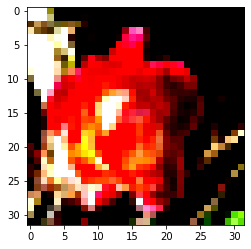

In [33]:
test_data = X_test[-1].reshape(1,32,32,3)
pred_y = model.predict(test_data)
pred_y = pred_y.argmax()

print('predict label : ',Y_test[-1])
plt.imshow(X_test[-1], cmap='gray')